# Post-processing

Output of model will be segmentation probabilities.

We need to get labeled regions.

Mains steps:

* Binarize
* Label
* Remove small objects
* Close holes inside objects

In [1]:
from skimage.measure import label, regionprops

def post_process(pred, min_area=1000):
    pred_mask = np.argmax(pred, axis=2)
    lab = label(pred_mask)
    for obj in regionprops(lab):
        if( obj.area < min_area ):
            lab[lab==obj.label] = 0
        else:
            region = lab[obj.bbox[0]:obj.bbox[2],obj.bbox[1]:obj.bbox[3]]
            region[obj.filled_image] = obj.label

    return lab

## View some results from trained models:

In [1]:
import tensorflow as tf
%pylab inline
from skimage.transform import resize
import numpy as np

from FullImageDataGenerator import FullImageDataGenerator
from TileDataGenerator import TileDataGenerator
from BaseModel import BaseModel
from ShortSkipModel import ShortSkipModel
from LongSkipModel import LongSkipModel
from Evaluator import Evaluator

Populating the interactive namespace from numpy and matplotlib


In [2]:
#directory = 'e:/data/GlaS'
directory = "d:/Adrien/dataset/GlaS/train"
'''experiments = [
        {'datagen' : FullImageDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : FullImageDataGenerator,
        'model' : ShortSkipModel,
        'name' : 'short_skip_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : FullImageDataGenerator,
        'model' : LongSkipModel,
        'name' : 'long_skip_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : ShortSkipModel,
        'name' : 'short_skip_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : LongSkipModel,
        'name' : 'long_skip_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100}
        ]'''

experiments = [
        {'datagen' : TileDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'maximum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100}]

In [4]:
tf.keras.backend.clear_session()


In [3]:
for experiment in experiments:
    DataGenerator = experiment['datagen']
    Model = experiment['model']
    clf_name = experiment['name']
    image_size = experiment.get('image_size', (256,384))
    validation_size = experiment.get('validation_size', 10)
    overlap = experiment.get('overlap', 'minimum')
    
    tf.keras.backend.clear_session()
    generator = DataGenerator(1, validation_size, directory, image_size)
    model = Model(image_size, clf_name, loadFrom=f'{clf_name}.hdf5')
    
    min_area = 2000
    train_metrics = Evaluator.evaluate(model, generator, 'train', overlap=overlap, min_area=min_area)
    print(overlap, train_metrics.mean(axis=0))

minimum [0.8309875  0.718145   0.77286086]
maximum [0.83870346 0.72003772 0.77517825]


In [5]:
for experiment in experiments:
    DataGenerator = experiment['datagen']
    Model = experiment['model']
    clf_name = experiment['name']
    image_size = experiment.get('image_size', (256,384))
    validation_size = experiment.get('validation_size', 10)
    
    tf.keras.backend.clear_session()
    generator = DataGenerator(1, validation_size, directory, image_size)
    model = Model(image_size, clf_name, loadFrom=f'{clf_name}.hdf5')
    
    print(clf_name)
    for min_area in [250, 2000, 4000, 6000, 8000]:
        train_metrics = Evaluator.evaluate(model, generator, 'train', overlap='minimum', min_area=min_area)
        print(min_area, train_metrics.mean(axis=0))

base_model_full_image
250 [0.72731889 0.82960389 0.84143917]
2000 [0.89523362 0.79120213 0.84372633]
4000 [0.94087912 0.72286255 0.83539829]
6000 [0.9640284  0.65749677 0.82191051]
8000 [0.97206015 0.58729441 0.80134398]
short_skip_model_full_image
250 [0.73803292 0.81633064 0.84187514]
2000 [0.90761616 0.77076486 0.84141316]
4000 [0.94341801 0.70175861 0.83218771]
6000 [0.95437903 0.64441983 0.81916599]
8000 [0.95662309 0.58314853 0.80060339]
long_skip_model_full_image
250 [0.72301342 0.85687351 0.8549647 ]
2000 [0.92224868 0.81684476 0.85846936]
4000 [0.97365274 0.75238301 0.85296264]
6000 [0.99056085 0.68634122 0.83968139]
8000 [0.9923545  0.62460795 0.82028871]
base_model_tile
250 [0.57079717 0.75741986 0.76866331]
2000 [0.8309875  0.718145   0.77286086]
4000 [0.90407458 0.65666297 0.76532744]
6000 [0.91978307 0.6019878  0.75580625]
8000 [0.93303704 0.54571624 0.7329763 ]
short_skip_model_tile
250 [0.55606659 0.71070485 0.76890972]
2000 [0.84137508 0.68210948 0.77505349]
4000 [0.90

In [33]:
experiments = [
        {'datagen' : FullImageDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : FullImageDataGenerator,
        'model' : ShortSkipModel,
        'name' : 'short_skip_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : FullImageDataGenerator,
        'model' : LongSkipModel,
        'name' : 'long_skip_model_full_image',
        'lr' : 1e-3,
        'eps': 1e-7,
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : BaseModel,
        'name' : 'base_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : ShortSkipModel,
        'name' : 'short_skip_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100},
        {'datagen' : TileDataGenerator,
        'model' : LongSkipModel,
        'name' : 'long_skip_model_tile',
        'lr' : 1e-4,
        'eps': 1e-8,
        'overlap': 'minimum',
        'directory': directory,
        'max_epochs': 1000,
        'patience': 100}
        ]

for experiment in experiments:
    if experiment['name'] != 'long_skip_model_full_image': continue
    DataGenerator = experiment['datagen']
    Model = experiment['model']
    clf_name = experiment['name']
    image_size = experiment.get('image_size', (256,384))
    validation_size = experiment.get('validation_size', 10)
    
    tf.keras.backend.clear_session()
    generator = DataGenerator(1, validation_size, directory, image_size)
    model = Model(image_size, clf_name, loadFrom=f'{clf_name}.hdf5')
    
    min_area = 2000
    train_metrics = Evaluator.evaluate(model, generator, 'val', overlap='minimum', min_area=min_area)
    print(clf_name, train_metrics.mean(axis=0))

long_skip_model_full_image [0.88166667 0.66617965 0.80860371]


In [27]:
'''base_model_full_image = np.array([0.89523362,0.79120213, 0.84372643])
short_skip_model_full_image = np.array([0.90761616,0.77076486, 0.84141316])
long_skip_model_full_image = np.array([0.92224868,0.81684476, 0.8584695 ])
base_model_tile = np.array([0.8309875, 0.718145,   0.77286086])
short_skip_model_tile = np.array([0.84137508,0.68210948, 0.77505349])
long_skip_model_tile = np.array([0.84934184,0.68034824, 0.76748277])'''
base_model_full_image = np.array([0.87666667,0.66082251,0.80346626])
short_skip_model_full_image = np.array([0.89277778,0.67872294,0.8038757 ])
long_skip_model_full_image = np.array([0.88166667,0.66617965,0.80860371])
base_model_tile = np.array([0.90944444,0.58208874,0.7671873 ])
short_skip_model_tile = np.array([0.91944444,0.57119589,0.7764523 ])
long_skip_model_tile = np.array([0.94652778,0.56286255,0.76331786])

In [29]:
f1 = 2*base_model_full_image[0]*base_model_full_image[1]/(base_model_full_image[0]+base_model_full_image[1])
print(f1)

0.7535936861718164


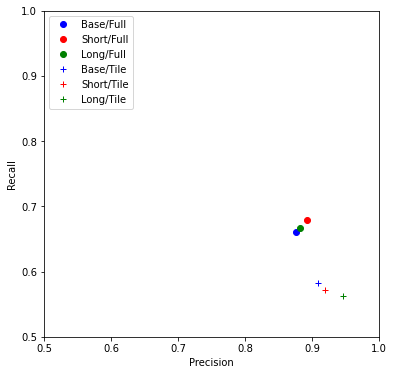

In [28]:
plt.figure(figsize=(6,6))
plt.plot(base_model_full_image[0], base_model_full_image[1], 'bo', label='Base/Full')
plt.plot(short_skip_model_full_image[0], short_skip_model_full_image[1], 'ro', label='Short/Full')
plt.plot(long_skip_model_full_image[0], long_skip_model_full_image[1], 'go', label='Long/Full')
plt.plot(base_model_tile[0], base_model_tile[1], 'b+', label='Base/Tile')
plt.plot(short_skip_model_tile[0], short_skip_model_tile[1], 'r+', label='Short/Tile')
plt.plot(long_skip_model_tile[0], long_skip_model_tile[1], 'g+', label='Long/Tile')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='upper left')
plt.show()

In [30]:
tile = isinstance(generator, TileDataGenerator)
data_x = [generator.full_images[idx] for idx in generator.val_idxs]
data_y = [generator.full_annotations[idx] for idx in generator.val_idxs]

In [7]:
# What is the size of the smallest gland in the training set?
min_s = 1e10
for idx in generator.train_idxs:
    anno = generator.full_annotations[idx]
    for i in range(1, anno.max()+1):
        s = (anno==i).sum()
        if s < min_s:
            min_s = s
            print(idx, i, min_s)

67 1 33885
67 2 1989
67 10 1948
67 11 995
43 1 2
61 6 1


(90.5, 0.0)


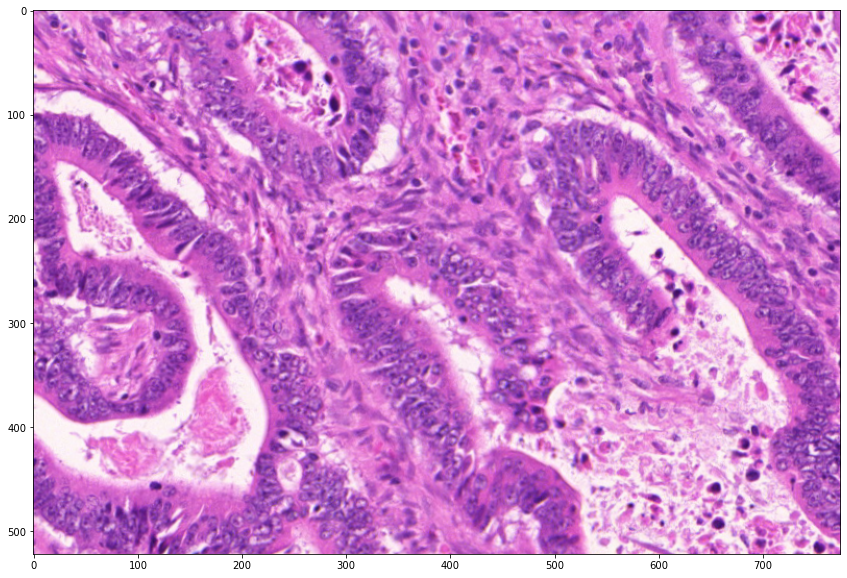

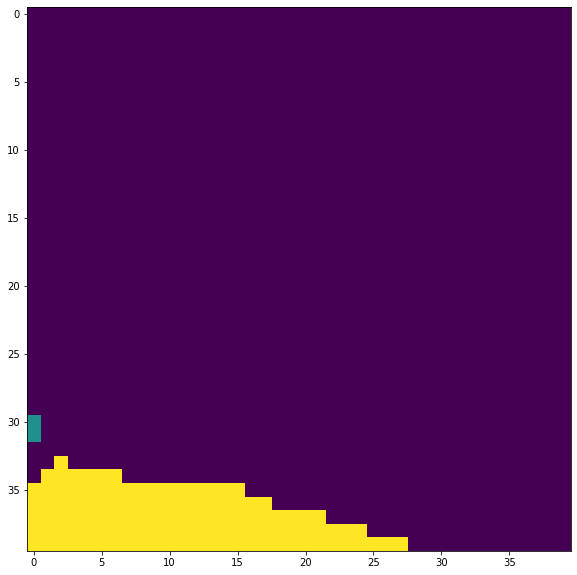

In [12]:
from skimage.measure import regionprops
objs = regionprops(generator.full_annotations[43])
plt.figure(figsize=(15,10))
plt.imshow(generator.full_images[43])
for obj in objs:
    if( obj.label == 1 ):
        print(obj.centroid)
plt.figure(figsize=(15,10))
plt.imshow(generator.full_annotations[43][60:100,:40])
plt.show()

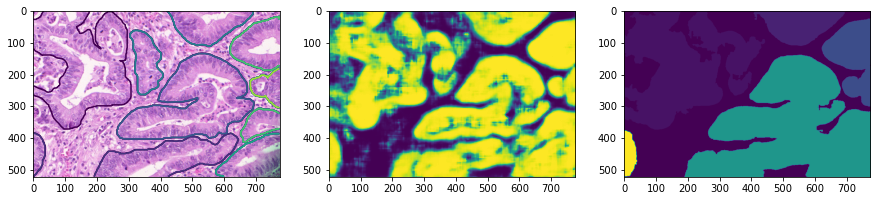

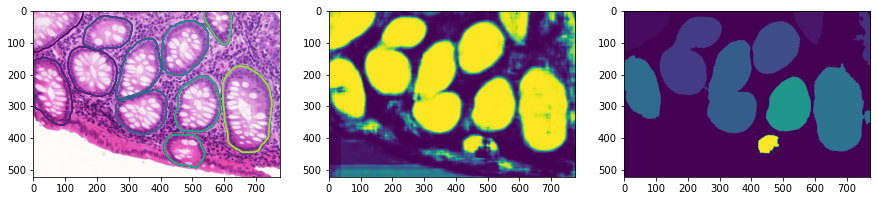

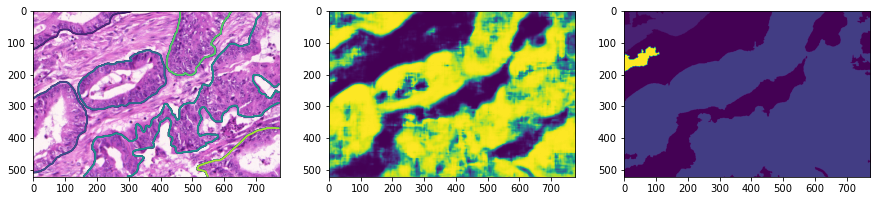

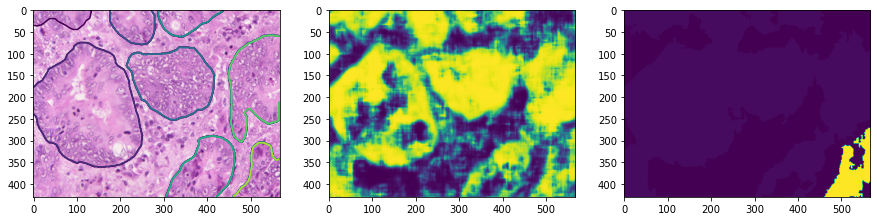

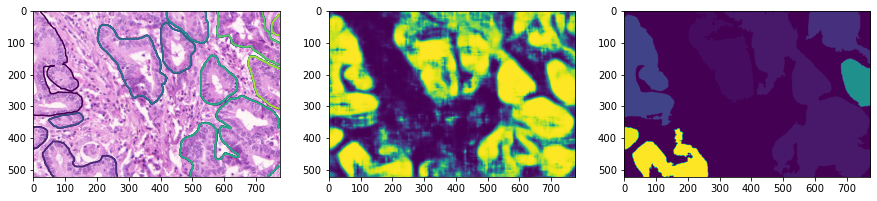

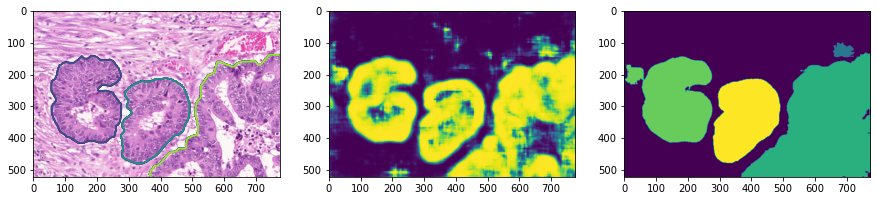

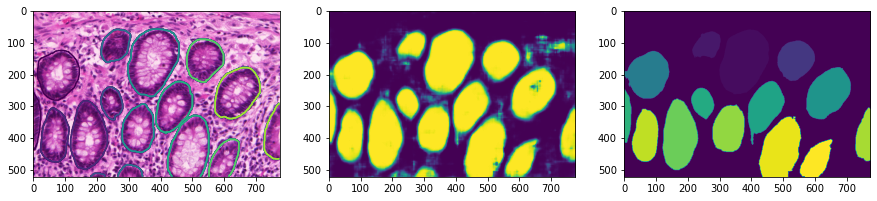

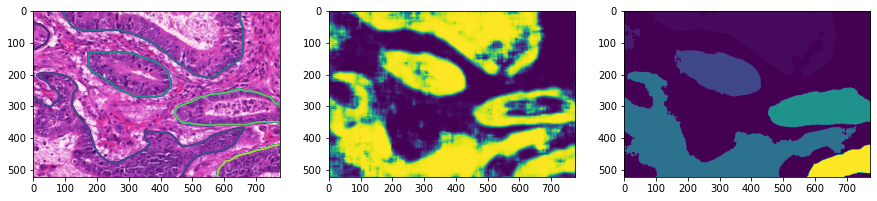

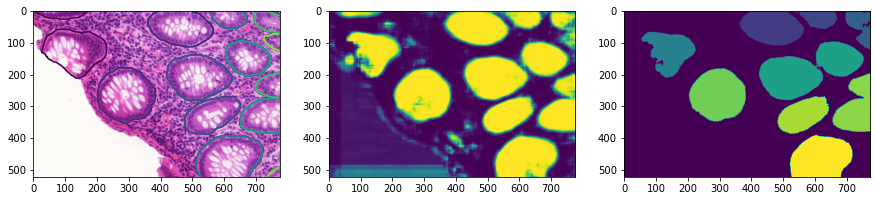

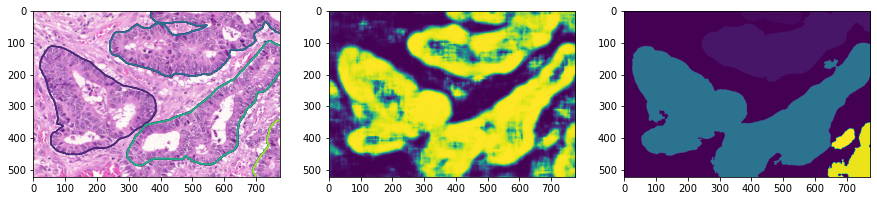

In [35]:
overlap = 'minimum'
for im, anno in zip(data_x, data_y):
    if( isinstance(generator, TileDataGenerator) ):
        tiles = generator._get_regular_tiling(im.shape, overlap)
        tiles_x = []
        tiles_y = []
        for tx,ty in tiles:
            tiles_x += [im[ty:ty+generator.tile_size[0],tx:tx+generator.tile_size[1]]]
            tiles_y += [anno[ty:ty+generator.tile_size[0],tx:tx+generator.tile_size[1]]]
        tiles_prediction = model.predict(np.array(tiles_x))

        pred_image = generator.stitch(tiles_prediction, anno.shape, overlap)
        pred_labels = model.post_process(pred_image, 2000)
    else:
        im_ = generator.preprocess_image(im)
        pred_image = resize(model.predict(np.array([im_]))[0], im.shape[:2])
        pred_labels = model.post_process(pred_image, 2000)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.contour(anno)
    plt.subplot(1,3,2)
    plt.imshow(pred_image[:,:,1])
    plt.subplot(1,3,3)
    plt.imshow(pred_labels)
    plt.show()
    